In [137]:
import os

import torch
from torch import nn
from torch.utils.data import Dataset
import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt

In [138]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using {device}")

Using cuda


In [139]:
IMAGE_SIZE = 128 #Actual frames = 1440. must be power of 2
IMAGE_CHANNELS = 3
LATENT_VECTOR_SIZE = 100

In [140]:
def show_examples(model, title=None, big=False):
    """Display examples of generated images

    Args:
        model (nn.Module): The generator model to use
        title (str, optional): The title of the display. Defaults to None.
        big (bool, optional): If false, display 4x1 examples, if true, display 4x3. Defaults to False.
    """
    latent_space_samples = torch.randn((batch_size, LATENT_VECTOR_SIZE))
    generated_samples = model(latent_space_samples)

    generated_samples = generated_samples.detach()
    fig = plt.figure()
    if title:
        fig.text(0.5, 1.0 if big else 0.7, title, ha='center', va='center')
    for plot_idx, dataset_idx  in enumerate(torch.randint(len(generated_samples), (12 if big else 4,))):
        sub = plt.subplot(3 if big else 1, 4, plot_idx+1)
        plt.tight_layout()
        sub.axis('off')
        image = generated_samples[dataset_idx.item()].permute(1,2,0)
        plt.imshow(image *0.5 + 0.5)
    fig.show()

# Preparing training data
Here I have two datasets. The reason is that I initially wanted to generate images of myself, like a good egoistic human would. The problem was that the reference images are very similar, so the generator got good at generating the background and my hair. However, the face was just a blob, destroing the point. Also, when testing on the flower dataset, I noticed that the training went much faster. This is probably a result of better optimizations and transformations when reading the images. I could look closer into optimizing the `VetleDataset`, but the flowers were more interesting to look at anyway. I left the old dataset because it should work given training time.

In [141]:
class VetleDataset(Dataset):

    def __init__(self, sample_count, image_dir, transform=None):
        """
        Arguments:
            sample_count (int): How many samples
            image_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.sample_count = sample_count
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return self.sample_count

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        frameno = str(idx+1).zfill(4)
        filename = "frame" + frameno + ".png"

        img_name = os.path.join(self.image_dir,
                                filename)
        image = torchvision.io.read_image(img_name).float()
        

        if self.transform:
            image = self.transform(image)

        # Return image with a label. We won't use it, but it seems like tensorflow expects it
        return [image,0]

In [142]:
vetleTransform = transforms.Compose([ transforms.Resize(IMAGE_SIZE), transforms.Normalize(128,128)])

In [143]:
vetleDataset = VetleDataset(2905, "assets/frames/", transform=vetleTransform)

In [144]:
flowerTransform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),  
    transforms.RandomCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) 
])

In [145]:
flowerDataset = torchvision.datasets.Flowers102(root="assets", download=True, transform=flowerTransform)

In [146]:
SELECTED_DATASET = vetleDataset

Plot training data:

C:\Users\vmang\AppData\Local\Temp\ipykernel_19216\2381701216.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


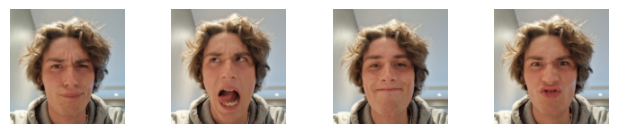

In [147]:
fig = plt.figure()
for plot_idx, dataset_idx  in enumerate(torch.randint(len(SELECTED_DATASET), (4,))):
    sub = plt.subplot(1, 4, plot_idx+1)
    plt.tight_layout()
    sub.axis('off')
    image = SELECTED_DATASET[dataset_idx.item()][0].permute(1,2,0)
    plt.imshow(image * 0.5 + 0.5)
fig.show()

Create data loader:

In [148]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    SELECTED_DATASET, batch_size=batch_size, shuffle=True
)


# The models


## Discriminator

In [149]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(IMAGE_CHANNELS, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),


            nn.Conv2d(512, 1024, 4, 2, 1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(1024, 1, 4, 1, 0, bias=False),
            nn.Sigmoid() 
        )

    def forward(self, x):
        output = self.model(x)
        return output.view(x.size(0),1)

In [150]:
discriminator = Discriminator()

## Generator

In [151]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
       
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels=LATENT_VECTOR_SIZE, out_channels=1024, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),


            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )

    def forward(self, x):
        x = x.view(x.size(0),LATENT_VECTOR_SIZE,1,1)
        return self.model(x)



C:\Users\vmang\AppData\Local\Temp\ipykernel_19216\3945074850.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


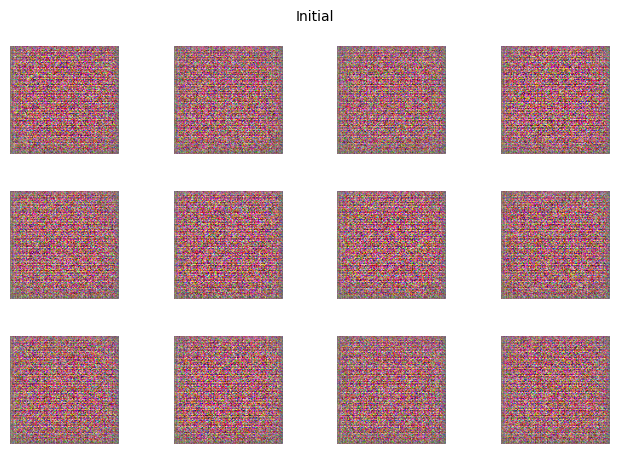

In [152]:
generator = Generator()
show_examples(generator, title="Initial", big=True)

# Training


## Hyperparameters

In [153]:
lr = 0.0002
num_epochs = 50
loss_function = nn.BCELoss()
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5,0.999))
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5,0.999))

Loop

0 
Epoch: 0 Loss D.: 0.011535421013832092
Epoch: 0 Loss G.: 10.037957191467285


C:\Users\vmang\AppData\Local\Temp\ipykernel_19216\3945074850.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


1 2 3 4 5 6 7 8 9 10 
Epoch: 10 Loss D.: 0.01865030638873577
Epoch: 10 Loss G.: 5.982626438140869
11 12 13 14 15 16 17 18 19 20 
Epoch: 20 Loss D.: 0.08636853098869324
Epoch: 20 Loss G.: 8.788362503051758
21 22 23 24 25 26 27 28 29 30 
Epoch: 30 Loss D.: 0.11034246534109116
Epoch: 30 Loss G.: 6.488607883453369
31 32 33 34 35 36 37 38 39 40 
Epoch: 40 Loss D.: 0.029548143967986107
Epoch: 40 Loss G.: 7.734084129333496
41 42 43 44 45 46 47 48 49 
Epoch: 49 Loss D.: 0.08406495302915573
Epoch: 49 Loss G.: 8.737987518310547


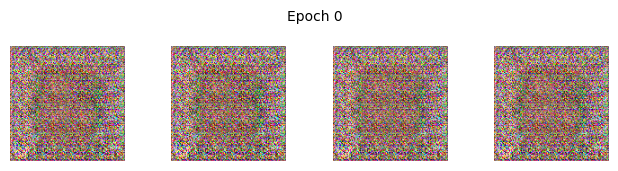

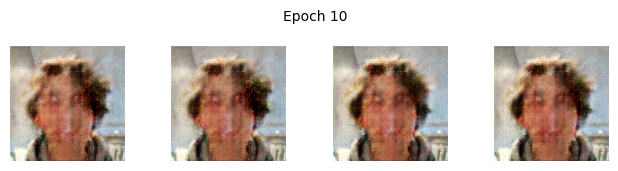

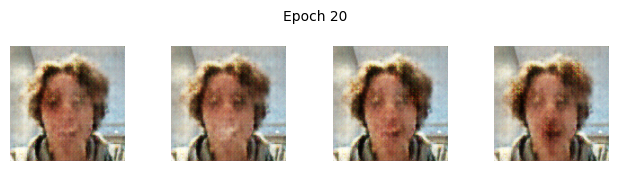

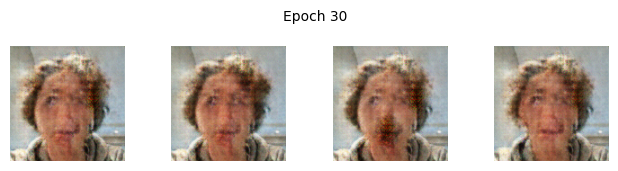

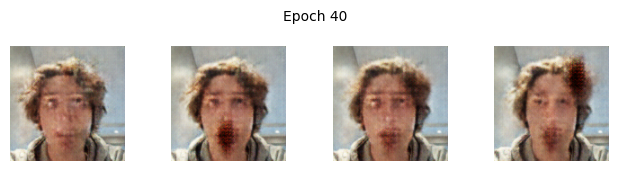

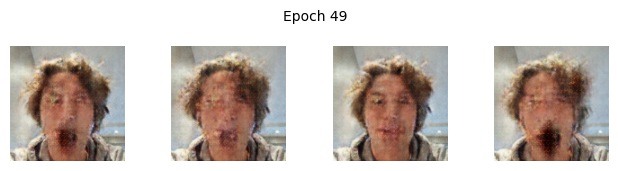

In [154]:
timeline = {
    "loss_discriminator":[],
    "loss_generator":[],
}
for epoch in range(num_epochs):
    print(epoch, end=" ")
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((real_samples.shape[0], 1))
        latent_space_samples = torch.randn((batch_size, LATENT_VECTOR_SIZE))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        discriminator_loss = 0
        ## First only real samples
        output_discriminator_real = discriminator(real_samples)
        loss_discriminator_real = loss_function(
            output_discriminator_real, real_samples_labels)
        loss_discriminator_real.backward()
        discriminator_loss += loss_discriminator_real.detach()
        
        ## Then only generated samples
        output_discriminator_gen = discriminator(generated_samples)
        loss_discriminator_gen = loss_function(
            output_discriminator_gen, generated_samples_labels)
        loss_discriminator_gen.backward()
        
        optimizer_discriminator.step()
        discriminator_loss += loss_discriminator_gen.detach()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, LATENT_VECTOR_SIZE))
        real_labels = torch.ones((batch_size, 1))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == len(train_loader) - 1:
            timeline["loss_discriminator"].append(discriminator_loss)
            timeline["loss_generator"].append(loss_generator.detach())
            if epoch % 10 == 0 or epoch == num_epochs -1:
                print("")
                print(f"Epoch: {epoch} Loss D.: {discriminator_loss}")
                print(f"Epoch: {epoch} Loss G.: {loss_generator}")
                show_examples(generator, title=f"Epoch {epoch}")
           

# Results
## Example images

C:\Users\vmang\AppData\Local\Temp\ipykernel_19216\3945074850.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


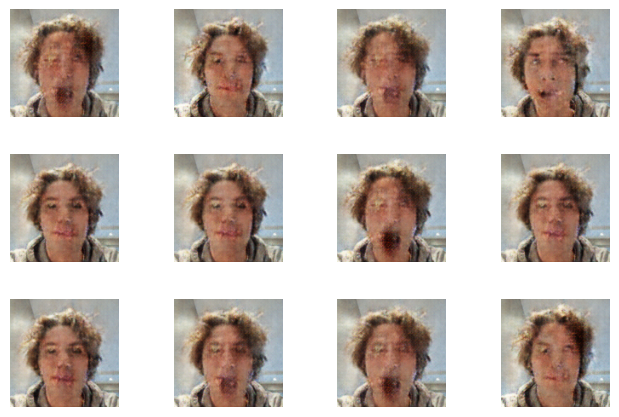

In [165]:
show_examples(generator, title="End Results", big=True)


## A look at lerping
I was concerned that the generator might overfit to the reference images. A perfect way to trick the discriminator is to "learn" one or a few of these images. A way to detect overfitting in GANs is to smoothly lerp between two different latent vectors and look for sudden "jumps" in the output image. A jump like this can signify that the generator has learnt a few examples, and is reciting them based on some value in the input noise.

If we see that the resulting flowers gradually change from one to another, we can guess that the generator actually generates meaningful properties.

C:\Users\vmang\AppData\Local\Temp\ipykernel_19216\2288870531.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


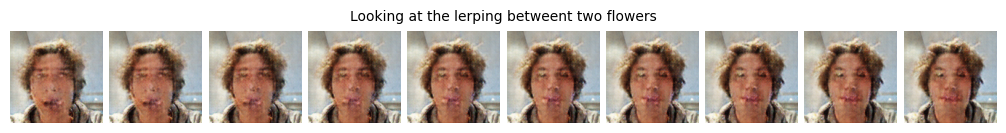

In [162]:
# Sample two random points in latent space
latent_space_endpoints = torch.randn((2, LATENT_VECTOR_SIZE))

# Generate a list of equally spaced points between the two endpoints
STEPS = 10
latent_space_samples = torch.empty(STEPS, LATENT_VECTOR_SIZE)
for i in range(STEPS):
    latent_space_samples[i] = torch.lerp(latent_space_endpoints[0], latent_space_endpoints[1],float(i)/float(STEPS+10))

# Generate images from the list of points
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.detach()

# Display the images in order
fig, axes = plt.subplots(1, STEPS, figsize=(10,2))
fig.text(0.5, 0.8, "Looking at the lerping betweent two flowers", ha='center', va='center')

for i  in range(STEPS):
    sub = plt.subplot(1, STEPS, i+1)
    sub.axis('off')
    image = generated_samples[i].permute(1,2,0)
    axes[i].imshow(image * 0.5 + 0.5)
plt.tight_layout(pad=0.5)
fig.show()

## Stats

C:\Users\vmang\AppData\Local\Temp\ipykernel_19216\4006500977.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.show()


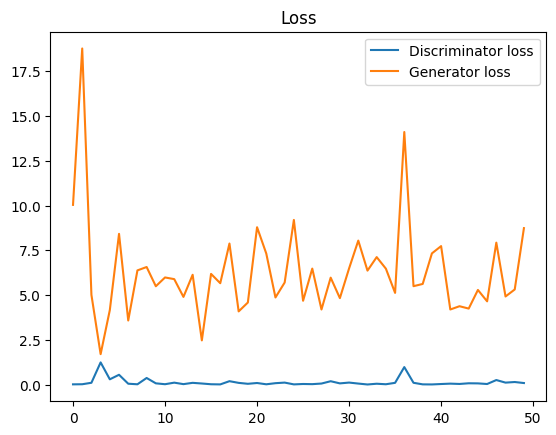

In [157]:
plot = plt.figure()
plt.plot(range(0, num_epochs), timeline["loss_discriminator"], label="Discriminator loss")
plt.plot(range(0, num_epochs), timeline["loss_generator"], label="Generator loss")
plt.title("Loss")
plt.legend()
plot.show()

# Save model

It's a dumb and simple saving system. To save the generator, set `SAVE` to true, and give it a `NAME`. To load a previously saved generator, set `SAVE` to false, and input the `NAME` of the model to load.

In [166]:
SAVE = False
NAME = "Faces"
path = f"saved/{NAME}.gangrud"
if SAVE:
    torch.save(generator.state_dict(), path)

## View saved model

In [171]:
saved_model = Generator()
saved_model.load_state_dict(torch.load(path))

<All keys matched successfully>

C:\Users\vmang\AppData\Local\Temp\ipykernel_19216\3945074850.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


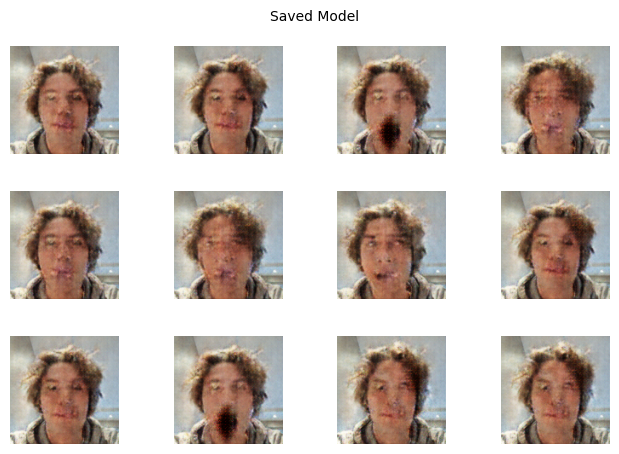

In [172]:
show_examples(saved_model, title="Saved Model", big=True)